In [1]:
import numpy as np
import matplotlib.pyplot as plt
import json

import adaptivealgo.cli.policy_iter as pi

In [2]:
links = [2, 3, 4, 5]
f_thresh = 0.5
actions = [0.1, 0.2, 0.3, 0.4]
alpha = 1.0
gamma = 0.1
tol = 1e-6

policies = {}
for n_links in links:
    policy, i = pi.find_policy(n_links, f_thresh, actions, alpha, gamma, tol)
    policies[n_links] = policy["policy"]
    print(f"Finding policy for n_links={n_links} converged in {i} iterations")

Finding policy for n_links=2 converged in 2 iterations
Finding policy for n_links=3 converged in 3 iterations
Finding policy for n_links=4 converged in 3 iterations
Finding policy for n_links=5 converged in 4 iterations


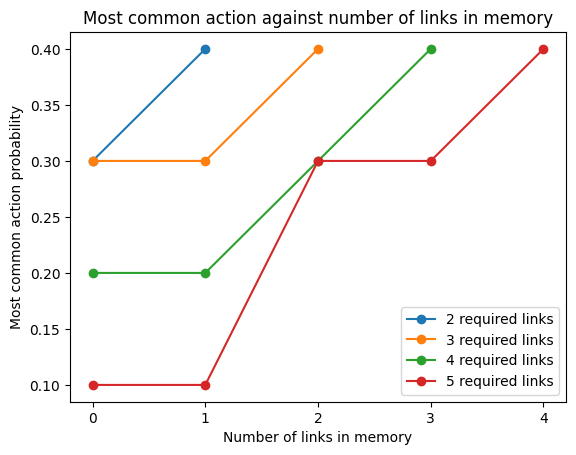

In [3]:
all_actions = {}

for n_links, policy in policies.items():
    all_actions[n_links] = {}
    for state, action in policy.items():
        state_list = json.loads(state)
        state_length = len(state_list)
        if state_length not in all_actions[n_links]:
            all_actions[n_links][state_length] = []
        all_actions[n_links][state_length].append(action)

mc_actions = {}

for n_links, policy in all_actions.items():
    for state_length, state_actions in policy.items():
        mc_action_idx = max(set(state_actions), key=state_actions.count)
        if n_links not in mc_actions:
            mc_actions[n_links] = {}
        mc_actions[n_links][state_length] = actions[mc_action_idx]

for n_links, policy in mc_actions.items():
    x = list(policy.keys())
    y = list(policy.values())
    plt.plot(x, y, label=f"{n_links} required links", marker='o')

plt.title("Most common action against number of links in memory")
plt.xlabel("Number of links in memory")
plt.ylabel("Most common action probability")

plt.xticks(np.arange(0, max(mc_actions.keys()), 1))
plt.legend()

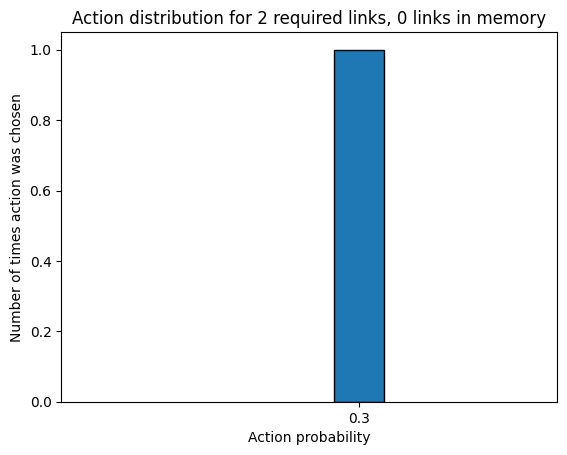

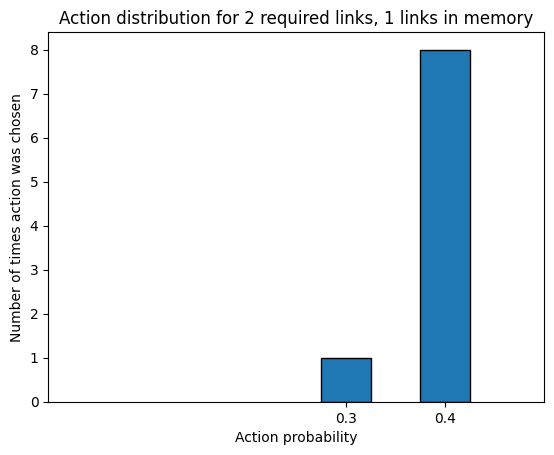

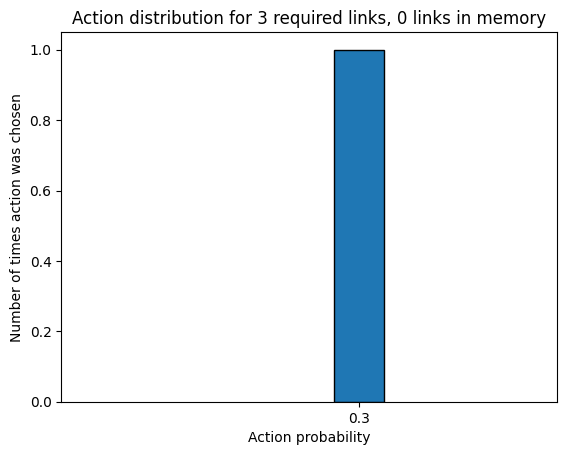

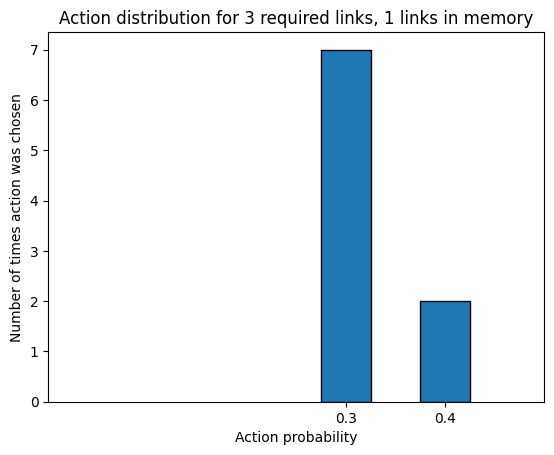

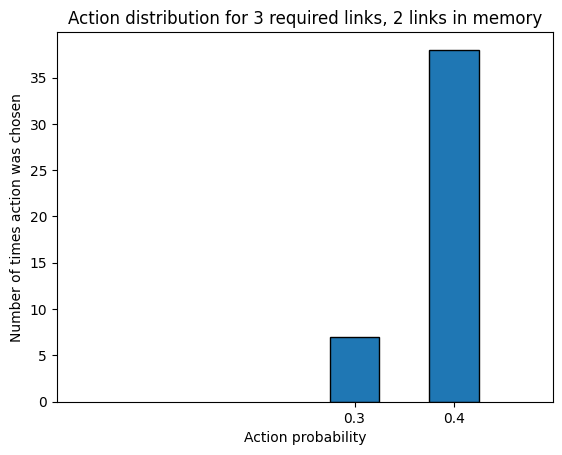

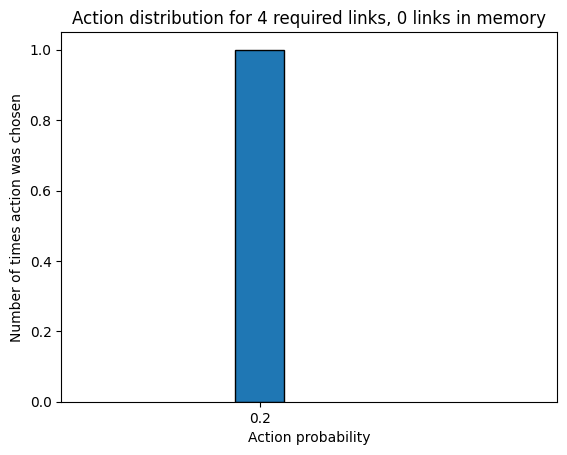

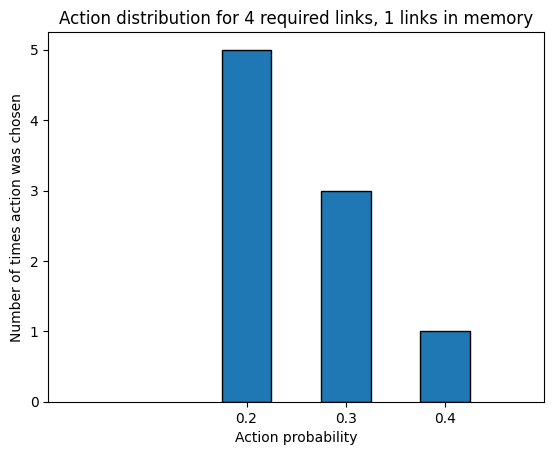

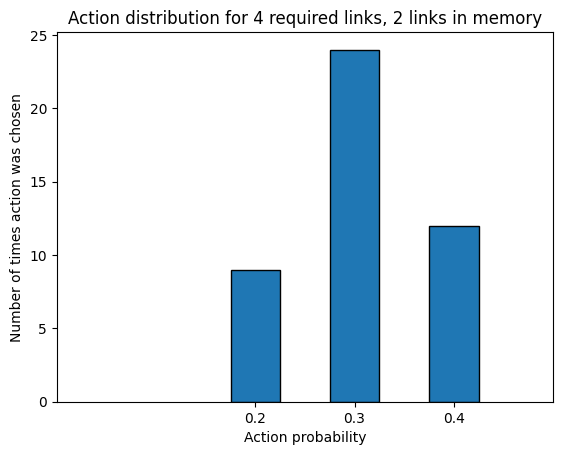

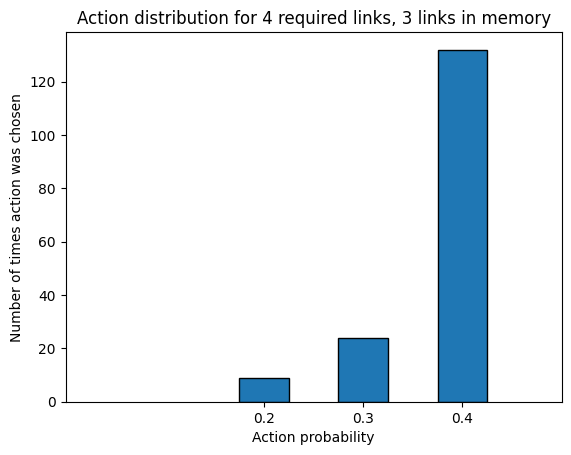

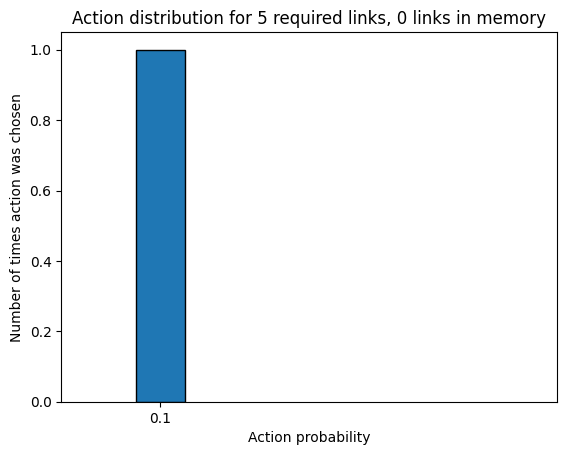

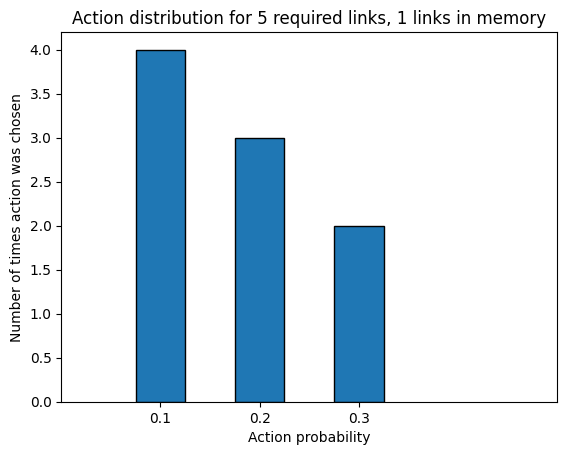

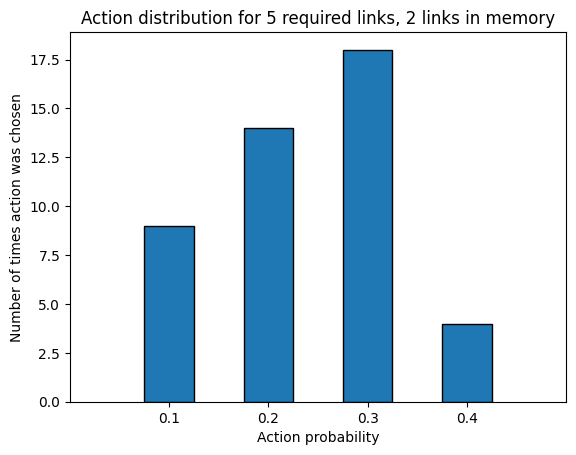

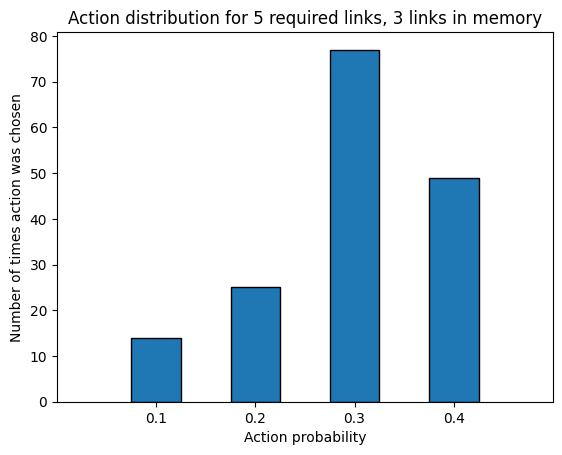

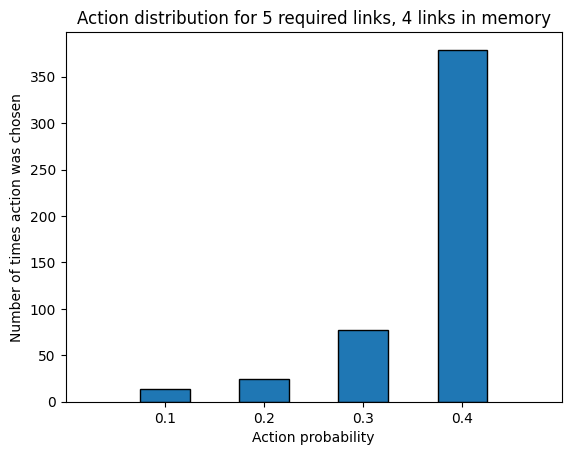

In [4]:
for n_links, policy in all_actions.items():
    for state_length, actions_idxs in policy.items():
        state_actions = [actions[idx] for idx in actions_idxs]
        plt.figure()
        labels, counts = np.unique(state_actions, return_counts=True)
        plt.bar(labels, counts, align='center', width=0.05, edgecolor='black')
        plt.gca().set_xticks(labels)
        plt.gca().set_xticklabels(labels)
        plt.gca().set_xbound(min(actions) - 0.1, max(actions) + 0.1)
        plt.xlabel(f"Action probability")
        plt.ylabel("Number of times action was chosen")
        plt.title(f"Action distribution for {n_links} required links, {state_length} links in memory")
        plt.show()

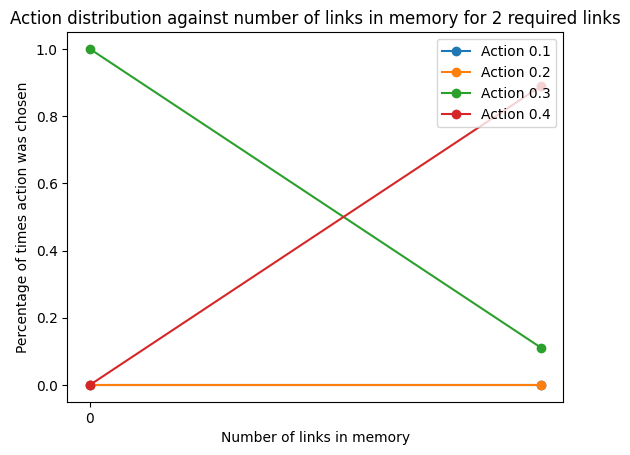

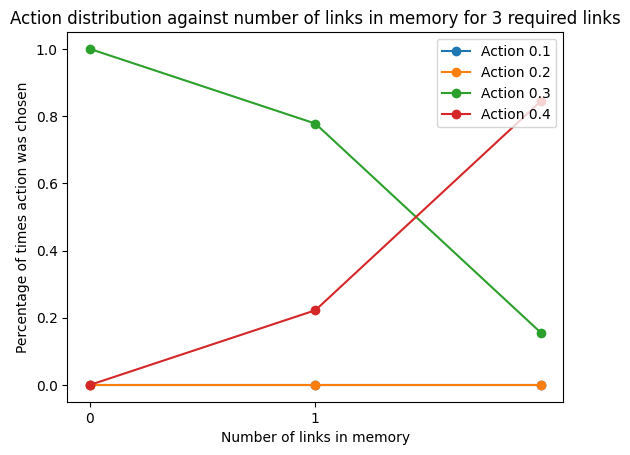

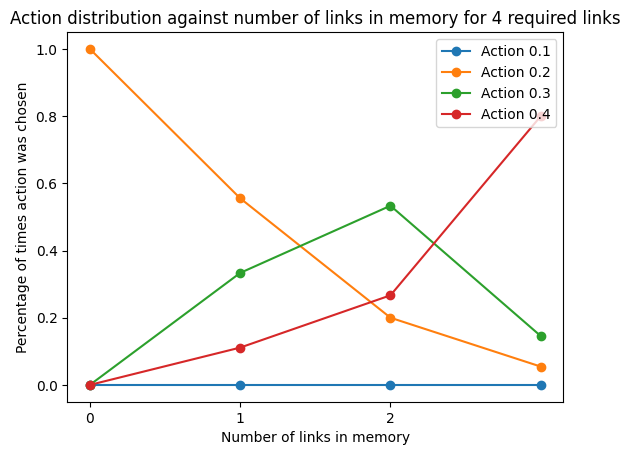

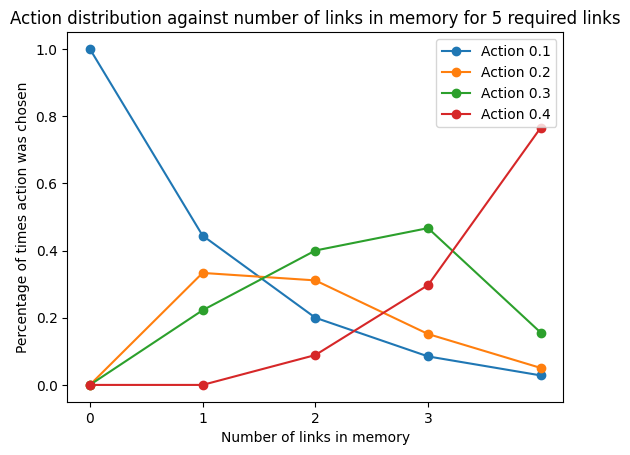

In [5]:
for n_links, policy in all_actions.items():
    actions_chosen = {}
    for state_length, actions_idxs in policy.items():
        state_actions = [actions[idx] for idx in actions_idxs]
        labels, counts = np.unique(state_actions, return_counts=True)
        actions_chosen[state_length] = dict(zip(labels, counts))
    
    for state_length, actions_chosen_state in actions_chosen.items():
        total = sum(actions_chosen_state.values())
        for action, count in actions_chosen_state.items():
            actions_chosen_state[action] = count / total

    for action in actions:
        y = [actions_chosen[state_length].get(action, 0) for state_length in actions_chosen.keys()]
        plt.plot(list(actions_chosen.keys()), y, label=f"Action {action}", marker='o')
        plt.xticks(np.arange(0, max(actions_chosen.keys()), 1))

    plt.title(f"Action distribution against number of links in memory for {n_links} required links")
    plt.xlabel("Number of links in memory")
    plt.ylabel("Percentage of times action was chosen")
    plt.legend(loc='upper right')
    plt.show()

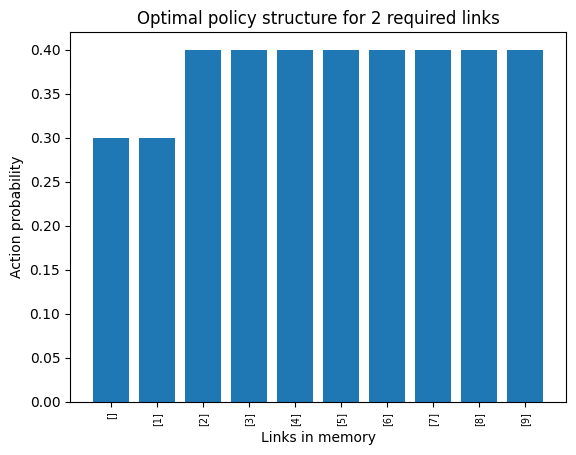

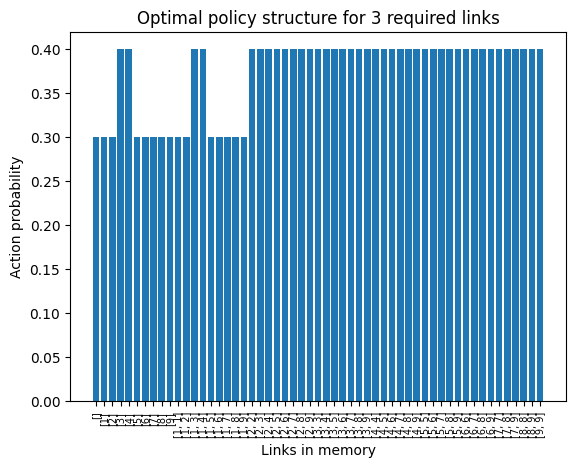

In [6]:
links = [2, 3]

for n_links in links:
    policy = policies[n_links]

    x = list(policy.keys())
    y = [actions[action] for action in policy.values()]
    plt.bar(x, y, label=f"{n_links} required links")

    plt.xticks(rotation=90, fontsize=7)

    plt.title(f"Optimal policy structure for {n_links} required links")
    plt.xlabel("Links in memory")
    plt.ylabel("Action probability")
    plt.show()

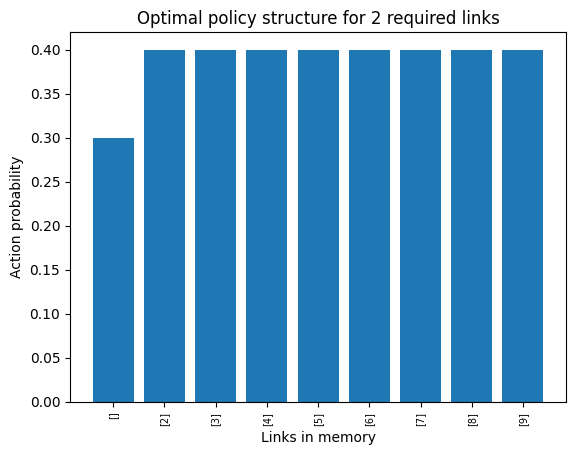

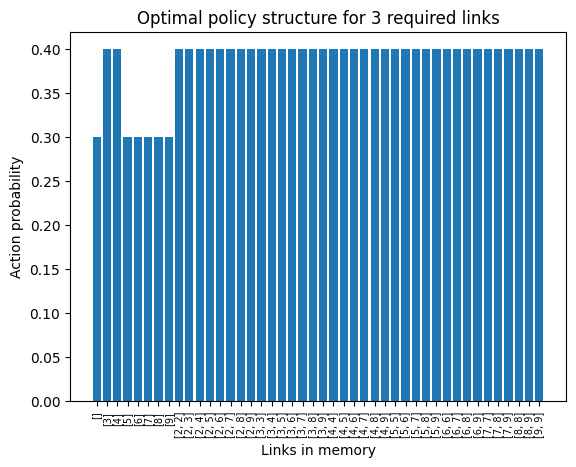

In [8]:
links = [2, 3]

def trim_state(state: list[int], n_links: int) -> list[int]:
    """
    Remove the links that will never survive for the given number of links
    required in memory

    :param list[int] state: The state
    :param int n_links: The number of links required
    :returns list[int]: The trimmed state
    """

    prev_state = state
    state = [ttl for ttl in state if ttl > n_links - len(state)]

    while len(prev_state) != len(state):
        prev_state = state
        state = [ttl for ttl in state if ttl > n_links - len(state)]

    return state

for n_links in links:
    policy = policies[n_links]
    trimmed_policy = []

    for k, v in policy.items():
        has_equiv = False
        k = json.loads(k)
        
        if len(trim_state(k, n_links)) == len(k):
            trimmed_policy.append((k, v))

    x = list([str(state) for state, _ in trimmed_policy])
    y = [actions[action] for action in [action for _, action in trimmed_policy]]
    plt.bar(x, y, label=f"{n_links} required links")

    plt.xticks(rotation=90, fontsize=7)

    plt.title(f"Optimal policy structure for {n_links} required links")
    plt.xlabel("Links in memory")
    plt.ylabel("Action probability")
    plt.show()